In [1]:
import sys
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(color_codes=True)
import random

sys.path.insert(0, "../utils/")
from data_loader import load_train_test_data, load_data
from matplotlib.pyplot import gcf

In [2]:
random.seed(18)
print(random.random())

0.18126486333322134


In [3]:
# load the data
data_directory = pathlib.Path("../0.data-download/data").resolve()
train_init, test_init, val_init, gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True, drop_columns=False
)

train_df, test_df, val_df, gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True, drop_columns=True
)


#data_dir = "../0.data-download/data/"
model_df, effect_df = load_data(data_directory, adult_or_pediatric="all")

In [4]:
train_init["train_test_val"] = train_init.apply(lambda _: "train", axis=1)
test_init["train_test_val"] = test_init.apply(lambda _: "test", axis=1)
val_init["train_test_val"] = val_init.apply(lambda _: "val", axis=1)

In [5]:
# load the latent dimension dataframe

latent_df = pd.read_parquet("../2.train-VAE/results/latent_df.parquet")

print(latent_df.shape)

latent_df.head(5)

(958, 37)


,ModelID,0,1,2,3,4,5,6,7,8,...,26,27,28,29,30,31,32,33,34,35
0,ACH-000361,0.0,1.099584,0.483426,0.0,0.0,0.0,3.926651,3.555450,2.703757,...,0.0,0.0,1.801697,0.000000,1.085674,0.033124,2.029070,0.678548,0.0,0.0
1,ACH-000976,0.0,1.320527,0.589153,0.0,0.0,0.0,3.117134,3.254976,1.898335,...,0.0,0.0,1.234270,0.000000,1.411566,0.000000,1.816989,0.860827,0.0,0.0
2,ACH-000279,0.0,2.306415,1.097857,0.0,0.0,0.0,5.333963,4.148107,3.945496,...,0.0,0.0,2.756601,0.037104,2.124590,0.406858,2.832798,1.494976,0.0,0.0
3,ACH-000515,0.0,2.367141,1.222137,0.0,0.0,0.0,4.301870,3.286340,3.075822,...,0.0,0.0,2.143998,0.177209,2.321284,0.239304,2.340215,1.512172,0.0,0.0
4,ACH-001523,0.0,1.118071,0.446705,0.0,0.0,0.0,5.064431,4.382661,3.610594,...,0.0,0.0,2.462133,0.000000,1.135513,0.004790,2.150859,0.728356,0.0,0.0


In [6]:
# create a data frame of both test and train gene effect data sorted by top 1000 highest gene variances
concat_frames = [train_init, test_init, val_init]
train_and_test = pd.concat(concat_frames).reset_index(drop=True)
train_and_test[["AgeCategory", "Sex"]] = train_and_test.age_and_sex.str.split(
    pat="_", expand=True
)

metadata_holder = []
metadata_holder = pd.DataFrame(metadata_holder)
metadata = metadata_holder.assign(
    ModelID=train_and_test.ModelID.astype(str),
    AgeCategory=train_and_test.AgeCategory.astype(str),
    Sex=train_and_test.Sex.astype(str),
    train_test_val=train_and_test.train_test_val.astype(str),
)
metadata

,ModelID,AgeCategory,Sex,train_test_val
0,ACH-000361,Adult,Male,train
1,ACH-000976,Adult,Male,train
2,ACH-000279,Pediatric,Unknown,train
3,ACH-000515,Adult,Male,train
4,ACH-001523,Adult,Male,train
...,...,...,...,...
953,ACH-001402,Adult,Female,val
954,ACH-000834,Adult,Male,val
955,ACH-001498,Adult,Female,val
956,ACH-001795,Adult,Female,val


In [7]:
AgeCategory = metadata.pop("AgeCategory")
Sex = metadata.pop("Sex")
train_test = metadata.pop("train_test_val")

/home/juliacurd/anaconda3/envs/gene_dependency_representations/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/juliacurd/anaconda3/envs/gene_dependency_representations/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


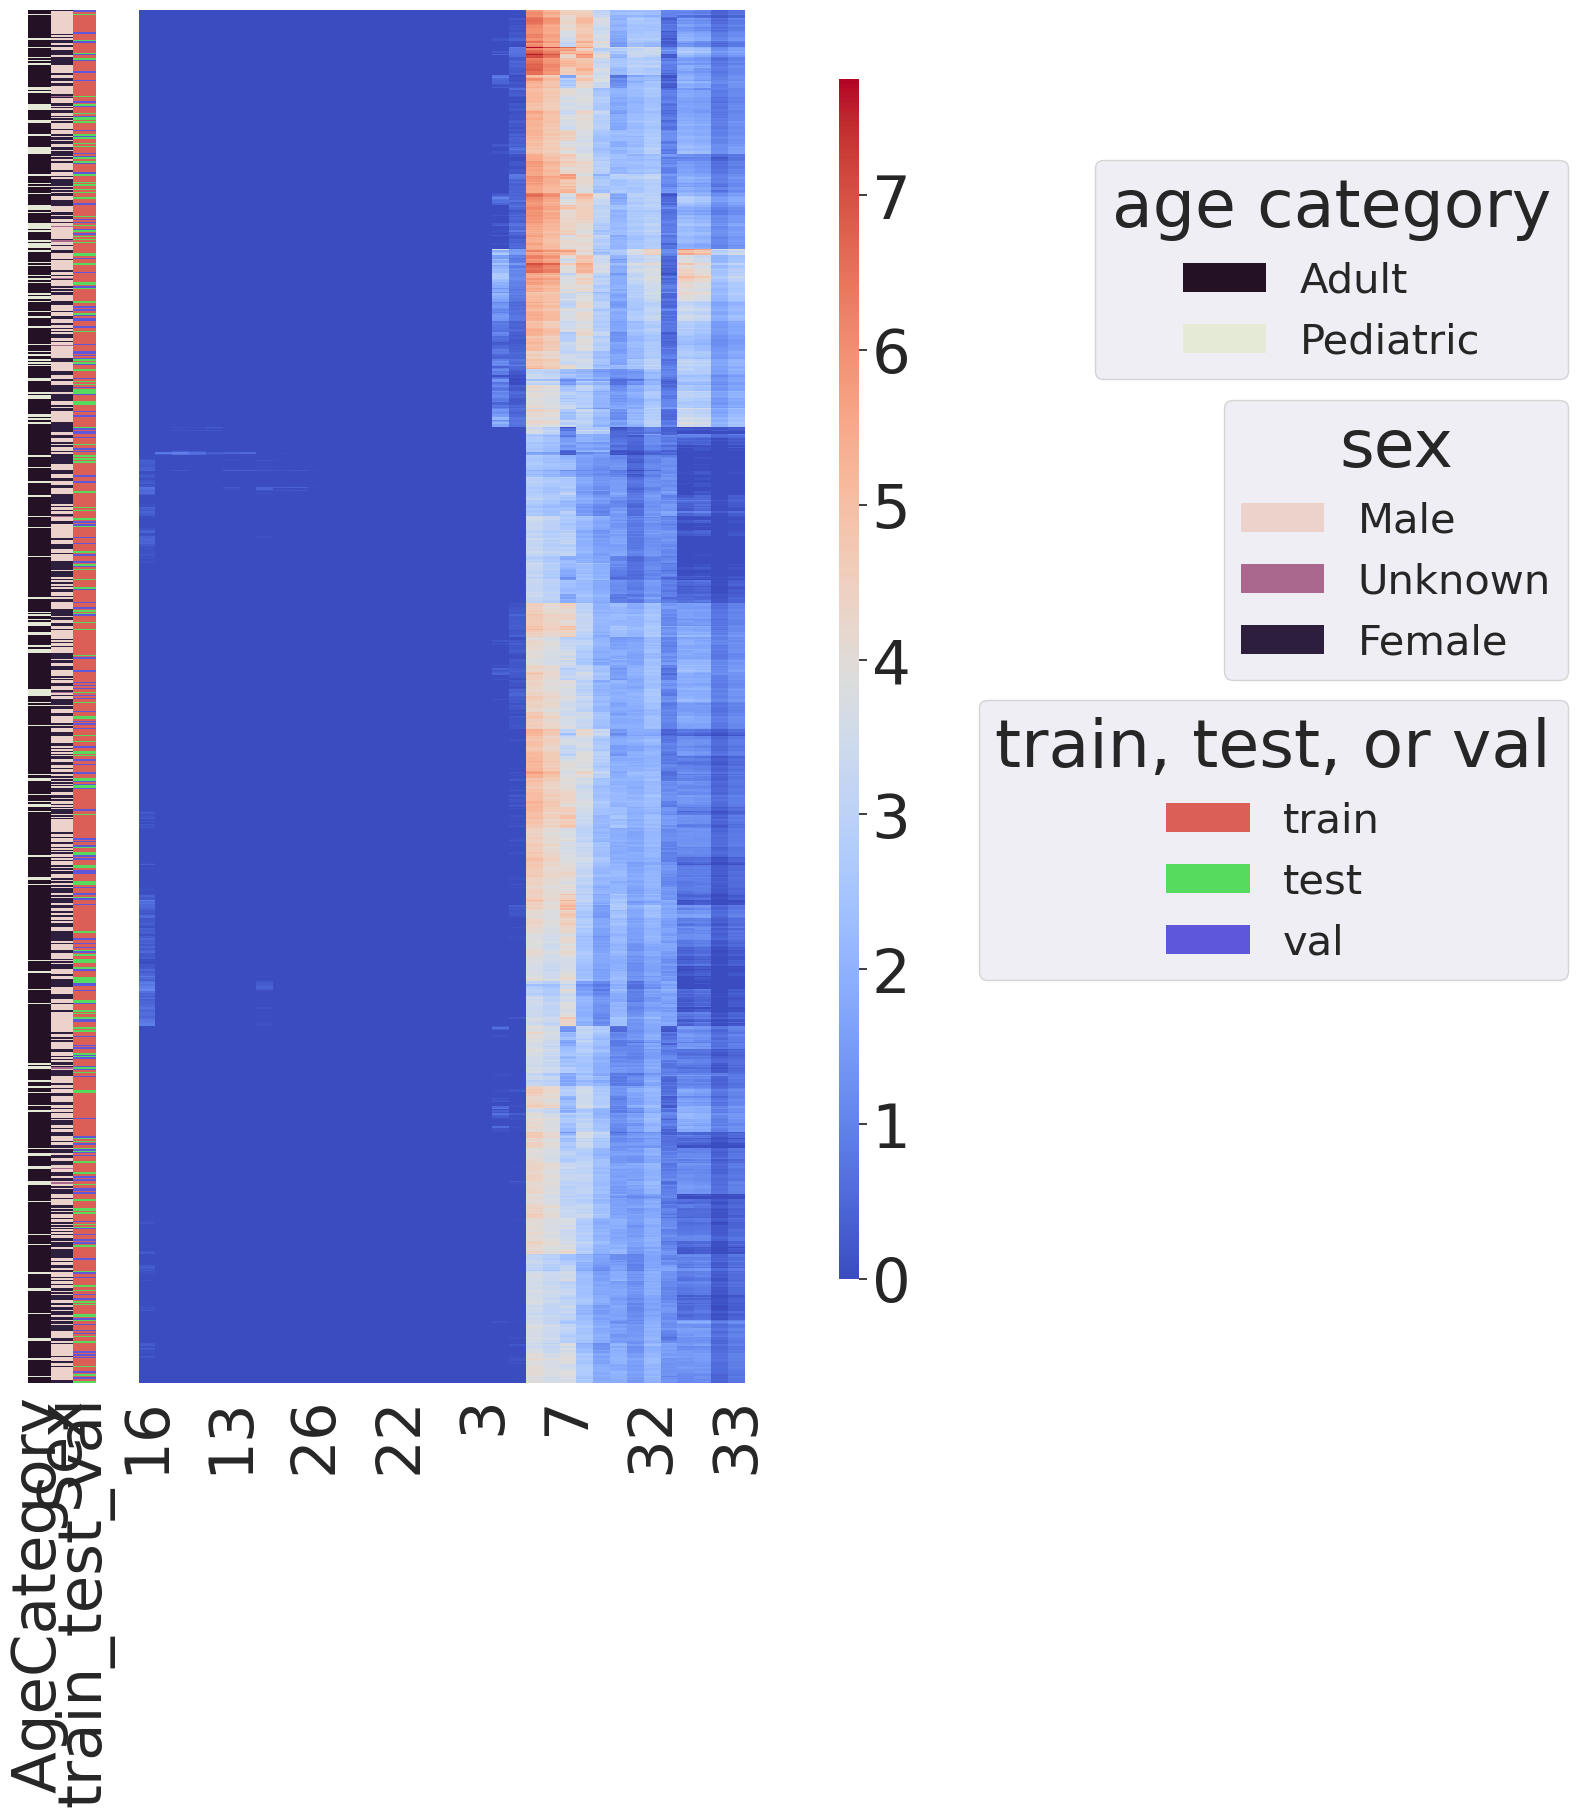

In [8]:
# display clustered heatmap of coefficients
lut_pal = sns.cubehelix_palette(
    AgeCategory.unique().size, light=0.9, dark=0.1, reverse=True, start=1, rot=-2
)
put_pal = sns.cubehelix_palette(Sex.unique().size)
mut_pal = sns.color_palette("hls", train_test.unique().size)

lut = dict(zip(AgeCategory.unique(), lut_pal))
put = dict(zip(Sex.unique(), put_pal))
mut = dict(zip(train_test.unique(), mut_pal))

row_colors1 = AgeCategory.map(lut)
row_colors2 = Sex.map(put)
row_colors3 = train_test.map(mut)

network_node_colors = pd.DataFrame(row_colors1).join(
    pd.DataFrame(row_colors2).join(pd.DataFrame(row_colors3))
)

sns.set(font_scale=4.0)
g = sns.clustermap(
    latent_df.iloc[:,1:],
    method="ward",
    figsize=(10, 20),
    row_colors=network_node_colors,
    yticklabels=False,
    dendrogram_ratio=(0.1, 0.04),
    cbar_pos=(1, 0.3, 0.02, 0.6),
    cmap = "coolwarm",
)
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)


xx = []
for label in AgeCategory.unique():
    x = g.ax_row_dendrogram.bar(0, 0, color=lut[label], label=label, linewidth=0)
    xx.append(x)
# add the legend
legend3 = plt.legend(
    xx,
    AgeCategory.unique(),
    loc="upper right",
    title="age category",
    ncol=1,
    bbox_to_anchor=(1.75, 0.87),
    bbox_transform=gcf().transFigure,
    fontsize = '30'
)


yy = []
for label in Sex.unique():
    y = g.ax_row_dendrogram.bar(0, 0, color=put[label], label=label, linewidth=0)
    yy.append(y)
# add the second legend
legend4 = plt.legend(
    yy,
    Sex.unique(),
    loc="upper right",
    title="sex",
    ncol=1,
    bbox_to_anchor=(1.75, 0.75),
    bbox_transform=gcf().transFigure,
    fontsize = '30'
)
plt.gca().add_artist(legend3)


zz = []
for label in train_test.unique():
    z = g.ax_row_dendrogram.bar(0, 0, color=mut[label], label=label, linewidth=0)
    zz.append(z)
# add the third legend
legend5 = plt.legend(
    zz,
    train_test.unique(),
    loc="upper right",
    title="train, test, or val",
    ncol=1,
    bbox_to_anchor=(1.75, 0.6),
    bbox_transform=gcf().transFigure,
    fontsize = '30'
)
plt.gca().add_artist(legend4)


# save the figure
heat_save_path = pathlib.Path("../1.data-exploration/figures/heatmap.png")
plt.savefig(heat_save_path, bbox_inches="tight", dpi=600)

In [9]:
# load the weights dataframe

gene_weights_df = pd.read_parquet("../2.train-VAE/results/weight_matrix_encoder.parquet")

gene_weights_df

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,0.112866,-0.126054,-0.206129,0.044076,-0.127843,0.001078,-0.068105,-0.136596,-0.073931,-0.038937,...,0.112638,-0.002000,0.018558,0.019899,0.023425,-0.047263,-0.023616,0.032459,-0.022189,0.090741
1,0.071179,-0.075100,-0.055322,0.048331,0.078016,0.072774,-0.048172,-0.072429,-0.024215,0.046140,...,0.021369,0.002923,-0.024067,0.002774,0.076762,-0.011417,0.041279,0.118828,0.025779,0.088937
2,0.020643,0.157906,0.158789,0.053516,-0.199032,-0.121920,0.031440,0.145072,0.052880,-0.168636,...,-0.057220,-0.000569,0.049257,0.084406,0.127840,-0.059191,0.001083,0.119540,0.032110,0.063436
3,0.097258,-0.147074,-0.182926,0.280665,0.292040,0.323171,-0.431678,-0.210640,-0.420061,0.140392,...,-0.110262,-0.033234,-0.046567,0.001170,0.018983,-0.049473,-0.047729,-0.031597,0.004874,0.015391
4,0.302754,0.099287,0.081394,0.341961,0.046994,0.178343,-0.237847,-0.344152,-0.165384,-0.027678,...,-0.093424,-0.115726,-0.036405,-0.130983,-0.039395,-0.150707,-0.082085,0.007228,-0.083000,0.020867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2713,-0.008678,-0.179711,-0.155342,0.089625,-0.047555,-0.019783,0.059989,0.125263,0.001473,-0.000214,...,-0.016499,0.104096,0.109699,0.003992,0.034125,0.031264,-0.011838,-0.059720,0.018660,-0.089277
2714,0.260255,-0.057844,-0.079670,0.342096,-0.009473,0.028051,-0.040120,-0.074758,-0.006371,-0.093182,...,-0.026417,-0.055749,-0.027152,-0.016435,-0.070581,-0.069690,0.046133,0.152594,-0.006710,0.034423
2715,0.211794,-0.089046,-0.132173,0.181616,0.118280,0.238060,-0.131380,-0.209050,-0.091110,0.113193,...,0.104577,-0.047935,0.024485,0.031712,0.124522,0.127811,0.156279,0.057151,0.098896,0.082902
2716,0.002625,-0.147330,-0.100843,-0.056174,0.086726,-0.000566,-0.014719,0.028123,-0.032661,0.089277,...,-0.072175,-0.034325,-0.070554,-0.036551,-0.085437,-0.047784,-0.019817,-0.047506,-0.051370,0.022076


/home/juliacurd/anaconda3/envs/gene_dependency_representations/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/juliacurd/anaconda3/envs/gene_dependency_representations/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


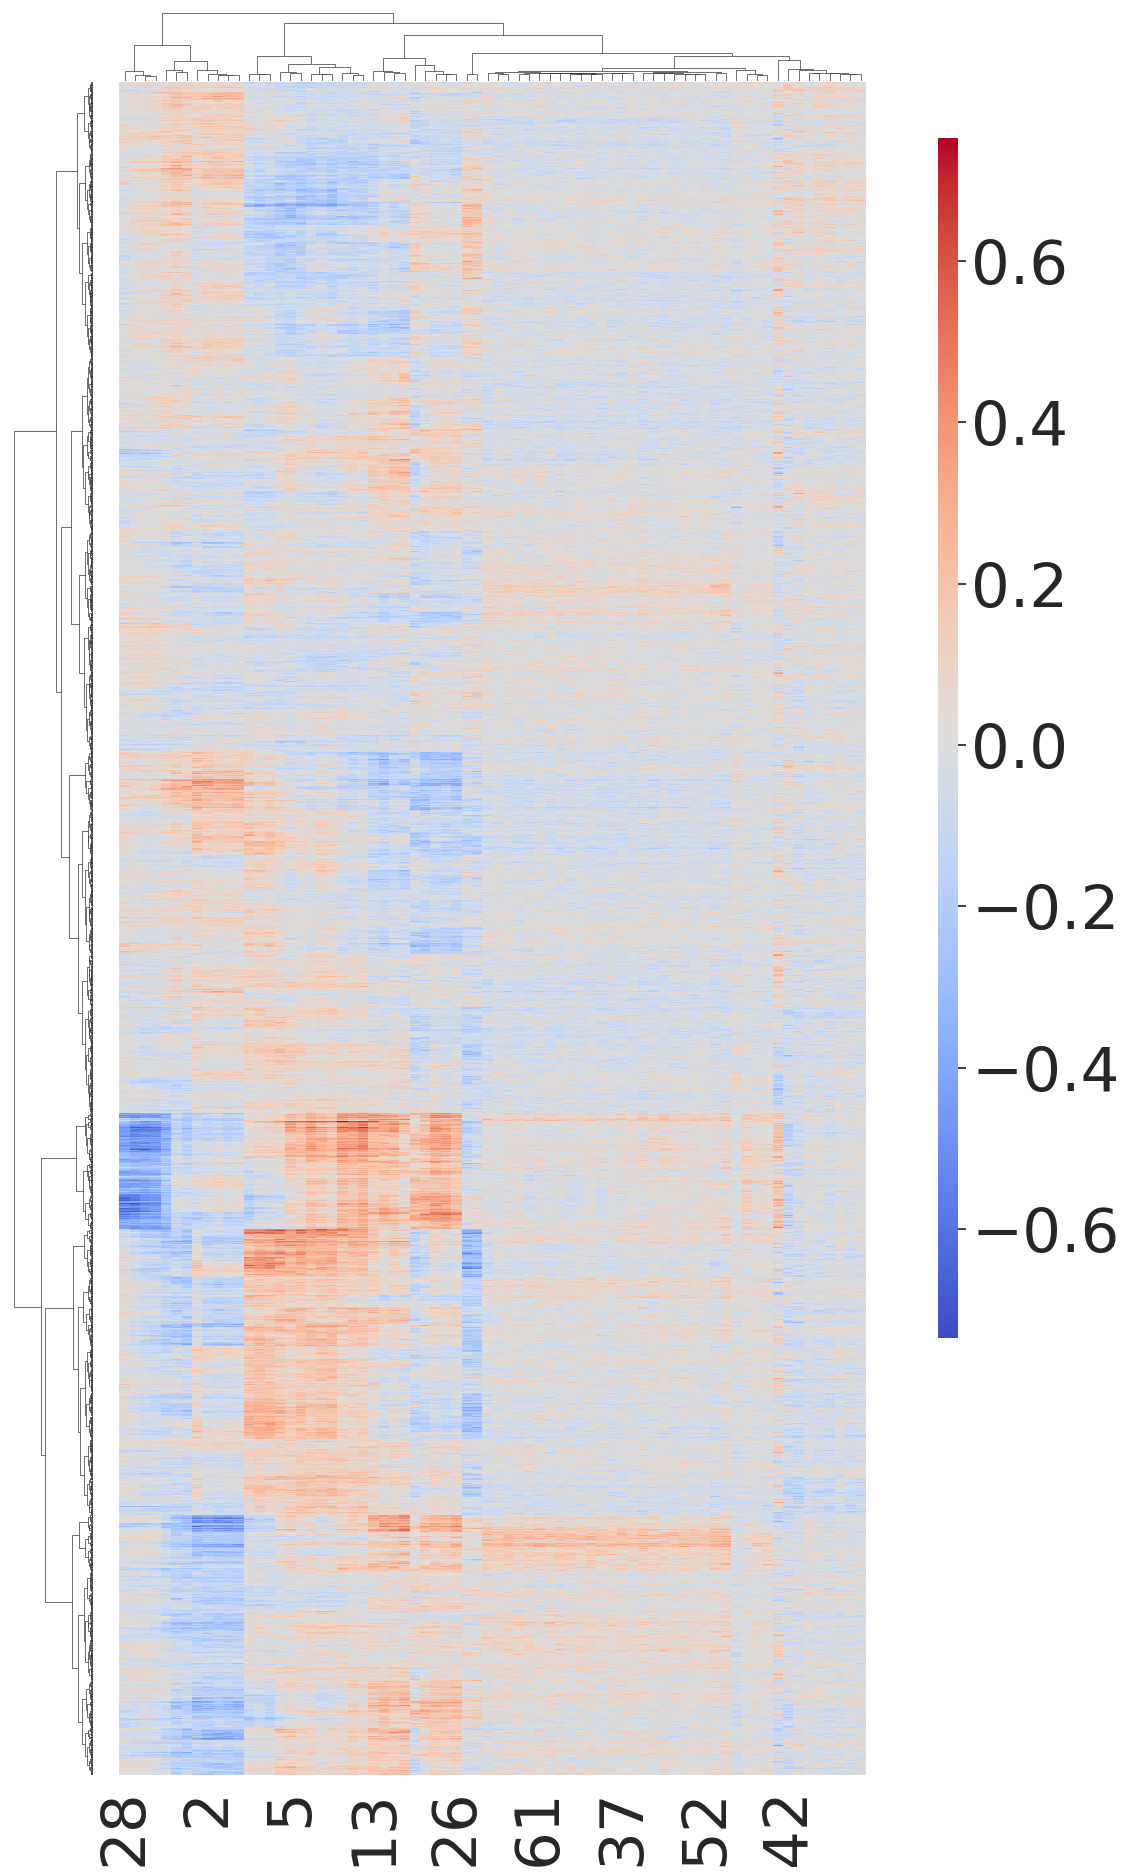

In [10]:
sns.clustermap(
    gene_weights_df,
    method="ward",
    figsize=(10, 20),
    #network_node_colors = pd.DataFrame(row_colors1).join(pd.DataFrame(row_colors2).join(pd.DataFrame(row_colors3))
    #row_colors=network_node_colors,
    yticklabels=False,
    dendrogram_ratio=(0.1, 0.04),
    cbar_pos=(1, 0.3, 0.02, 0.6),
    cmap = "coolwarm",
)
